<font size=3> **Goal:** The purpose of this notebook is to analyze the results after doing equilibration procedure on the full one square degree and compare them to previous results, see if we can proceed to money plot, etc. </font>

# Preamble

In [1]:
import os
from importlib import reload
os.chdir('/nfs/slac/g/ki/ki19/deuce/AEGIS/ismael/WLD')

%matplotlib inline 

import mycode
reload(mycode);

In [15]:
from mycode import money
from mycode import preamble
from mycode import weights 
from mycode import maps 

from tqdm import tqdm 

%run mycode/preamble.py

reload(weights)
reload(preamble)
reload(maps)
reload(money);

In [16]:
import astroML
from astroML.plotting import scatter_contour

In [17]:
from astropy.table import Table

In [18]:
data_dir = '/nfs/slac/g/ki/ki19/deuce/AEGIS/ismael/WLD/data'

## Read catalogues

In [6]:
#filters to apply as reading the catalogue. 
pfilters = [
    maps.get_non_duplicated_cat
]


ffilters = [
    maps.good, 
    maps.best,
    maps.low_cond,
    maps.not_dropped,
    maps.get_not_dropped_cat
]

In [7]:
pcat1, pcat2 = (Table.read(f"{data_dir}/projectLSST-g1_0-g2_0/final_fits.fits"), 
            Table.read(f"{data_dir}/projectLSST-g1_20-g2_0/final_fits.fits"))

pfcat1, pfcat2 = (Table.read(f"{data_dir}/fprojectLSST-g1_0-g2_0/final_fits.fits"), 
            Table.read(f"{data_dir}/fprojectLSST-g1_20-g2_0/final_fits.fits"))

In [8]:
cat1, cat2 = maps.get_filter_cats([pcat1, pcat2], pfilters) 
fcat1, fcat2 = maps.get_filter_cats([pfcat1, pfcat2], pfilters) 

In [9]:
scat1 = maps.get_filter_cats([cat1], ffilters)[0]
print(len(scat1))

#remember to not apply filters directly on cat2, but intersect
scat1, scat2 = maps.get_intersection_cats([scat1, cat2]) 
print(len(scat1),len(scat2))

77718
77657 77657


In [10]:
fscat1 = maps.get_filter_cats([fcat1], ffilters)[0]
print(len(fscat1))

#remember to not apply filters directly on cat2, but intersect
fscat1, fscat2 = maps.get_intersection_cats([fscat1, fcat2]) 
print(len(fscat1),len(fscat2))

112962
112857 112857


In [19]:
ncat1, grps_dropped = maps.get_not_dropped_cat(fcat1)

In [20]:
grps_dropped

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [14]:
fscat1[fscat1['grp_id'] ==402700494657]

db_id,grp_id,grp_size,grp_rank,visible,xmin,xmax,ymin,ymax,f_disk,f_bulge,dx,dy,z,ab_mag,ri_color,flux,sigma_m,sigma_p,e1,e2,a,b,beta,psf_sigm,purity,snr_sky,snr_iso,snr_grp,snr_isof,snr_grpf,ds,dg1,dg2,ds_grp,dg1_grp,dg2_grp,cond_num,cond_num_grp,bias_f,bias_s,bias_g1,bias_g2,bias_x,bias_y,bias_f_grp,bias_s_grp,bias_g1_grp,bias_g2_grp,bias_x_grp,bias_y_grp,match,ambig_blend
int64,int64,int16,int16,int16,int32,int32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bool
402700494657,402700494657,19,0,1,510,533,449,471,1.0,0.0,-1695.5658,-1347.8538,0.4992061,22.838982,0.39768982,520421.16,0.23458864,0.24206822,0.05405429,-0.16868296,0.28057858,0.19613694,-0.6303431,0.66373867,0.99989134,151.52008,146.83398,146.83398,101.3752,101.31863,0.029890532,0.025965594,0.028357863,0.02991165,0.025976473,0.028364532,18165.256,97036310.0,62.059395,-0.0012941572,0.00023396705,-0.00073013525,-7.4377243e-10,1.2597597e-09,-15.769251,-0.0018450043,0.00029840146,-0.001065895,1.7796629e-05,1.853901e-05,673,False
402703556120,402700494657,19,4,1,517,536,435,450,0.9710734,0.028926624,-1694.6135,-1351.396,1.9192578,25.178095,0.23033714,60354.5,0.41996112,0.47103733,0.26643786,-0.20804982,0.59707624,0.29538494,-0.3314794,0.7675292,0.9245406,14.24265,14.206702,14.204696,8.992982,8.588473,0.21570563,0.17816192,0.16599007,0.22055098,0.17863764,0.1665163,252.82948,97036310.0,807.71216,-0.04365888,0.03573281,-0.027894543,-7.334128e-07,-1.2688196e-06,635.5658,-0.049792796,0.036852658,-0.022558736,0.00049246324,-0.0007718652,675,False


In [13]:
fcat1[fcat1['snr_grpf']==0]

db_id,grp_id,grp_size,grp_rank,visible,xmin,xmax,ymin,ymax,f_disk,f_bulge,dx,dy,z,ab_mag,ri_color,flux,sigma_m,sigma_p,e1,e2,a,b,beta,psf_sigm,purity,snr_sky,snr_iso,snr_grp,snr_isof,snr_grpf,ds,dg1,dg2,ds_grp,dg1_grp,dg2_grp,cond_num,cond_num_grp,bias_f,bias_s,bias_g1,bias_g2,bias_x,bias_y,bias_f_grp,bias_s_grp,bias_g1_grp,bias_g2_grp,bias_x_grp,bias_y_grp,match,ambig_blend
int64,int64,int16,int16,int16,int32,int32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bool
402715437547,402715437547,1,0,1,241,242,771,772,1.0,0.0,-1751.6229,-1285.5322,0.2618824,27.691595,0.2834053,5960.8687,1.8064443,1.8074887,-0.021873478,0.009979549,1.8504105,1.7635226,1.356781,1.9094628,1.0,0.101934366,0.0,0.0,0.0,0.0,inf,inf,inf,inf,inf,inf,594526900000.0,594526900000.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-1,False
402706697704,402700494657,19,9,1,528,540,467,483,1.0,0.0,-1693.0583,-1344.8785,0.5464898,26.070274,0.50925255,26536.146,0.4147085,0.44213033,-0.2296023,-0.105944805,0.5370272,0.32025033,-1.3546382,0.7552295,0.95452285,6.2850804,6.2780514,0.0,3.9297848,0.0,0.45836145,0.40244237,0.3617644,inf,inf,inf,58.40635,97036310.0,2024.7913,-0.17915662,-0.14216052,-0.06553482,7.599813e-05,-5.8105536e-05,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-1,False
402717092316,402700494657,19,18,1,514,515,375,377,1.0,0.0,-1697.0077,-1364.7244,0.224671,28.005327,-0.01732254,4464.951,1.473204,1.483859,-0.07460007,0.040511172,1.6040546,1.3530277,1.3220526,1.5992051,0.67275935,0.12721609,0.0,0.0,0.0,0.0,inf,inf,inf,inf,inf,inf,872855900.0,97036310.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-1,True
402704388887,402700494657,19,6,1,502,515,373,389,0.86827326,0.13172671,-1698.2068,-1363.6987,1.3948318,25.4638,0.21162033,46390.324,0.34026715,0.34644553,-0.13060898,-0.030559566,0.3894287,0.29731175,-1.4558749,0.70812386,0.98533726,11.763794,11.737236,0.0,7.3463993,0.0,0.275881,0.24521936,0.2338644,inf,inf,inf,154.72388,97036310.0,945.16144,-0.07110515,-0.033263538,-0.007848147,-3.991719e-07,-2.38802e-06,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,588,True
402714836239,402711463342,2,1,1,387,387,882,882,1.0,0.0,-1722.5093,-1263.4984,0.3141114,27.594698,0.09174347,6517.3105,1.9420342,1.9836818,-0.1294853,-0.06670048,2.2488847,1.6770521,-1.3329611,2.0417964,0.12256181,0.05114367,0.0,0.0,0.0,0.0,inf,inf,inf,inf,inf,inf,20752904000000.0,79.58064,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-1,True
402715786407,402715786407,1,0,1,1285,1286,323,324,1.0,0.0,-1542.7816,-1015.1254,0.2053498,27.612814,-0.043613434,6409.4683,1.886674,1.8923167,-0.0032777481,-0.05454856,1.9927527,1.7862421,-0.8154064,1.9859554,1.0,0.10237916,0.0,0.0,0.0,0.0,inf,inf,inf,inf,inf,inf,94119550000.0,94119550000.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-1,False
402717427002,402702635483,2,1,1,1168,1169,413,414,1.0,0.0,-1566.2307,-997.204,2.1754398,29.89147,0.3426609,680.32794,0.14621106,0.17290093,0.11128518,0.39208344,0.22537048,0.094855696,0.64711964,0.641698,0.14691022,0.122467905,0.0,0.0,0.0,0.0,inf,inf,inf,inf,inf,inf,2849186500000.0,2273.9736,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-1,False
402700908851,402700001495,159,17,1,344,368,317,343,1.0,0.0,-1728.6998,-1013.85614,0.7627148,23.385746,0.7653427,314520.66,0.5571238,0.558999,-0.056275155,-0.013904724,0.59041166,0.52571267,-1.4496799,0.8330383,0.99891186,63.822186,63.20358,0.0,39.67386,0.0,0.03406938,0.030030217,0.029823316,inf,inf,inf,3945.218,65250107000.0,175.6072,-0.0008928141,-0.00016949885,-4.1730087e-05,-1.5417793e-08,-8.950215e-09,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,401,False
402707532717,402700001495,159,81,1,518,528,344,354,1.0,0.0,-1695.2339,-1010.14343,1.2033291,26.43

# Condition numbers

In [47]:
conds1 = np.log10(cat1[(fcat1['cond_num_grp'] < 1e20) & (cat1['cond_num_grp'] < 1e20)]['cond_num_grp'])
conds2 = np.log10(fcat1[(fcat1['cond_num_grp'] < 1e20) & (cat1['cond_num_grp'] < 1e20)]['cond_num_grp'])

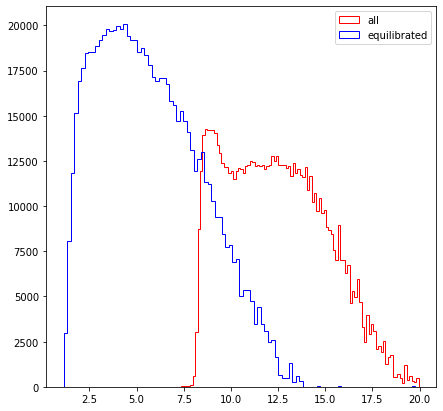

In [48]:
plt.figure(figsize=(7,7))
plt.hist(conds1, bins=100, color='red', 
         histtype='step', label='all');
plt.hist(conds2, bins=100, color='blue' ,
         histtype='step', label='equilibrated');
plt.legend()

<font size=3> **Note:** No significant difference found for the histograms in the case of applied shear case </font>

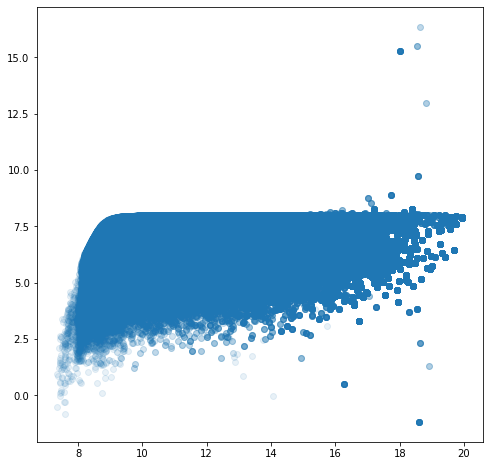

In [53]:
plt.figure(figsize=(8,8))
plt.scatter(conds1, conds1 - conds2, alpha=0.1)

# Weighting

In [55]:
def weights_bias_scatter(ax, cat, component, iso_or_grp, xlabel=None, title=None, xlim=(-5,5), size_dots=0.5, alpha=1): 
    orig_ids = list(range(len(cat)))
    ws = weights.get_weights(orig_ids, cat,  component, iso_or_grp, 'component')
    suffix = weights.get_iso_or_grp_suffix(iso_or_grp)

    ax.scatter(cat[f'bias_g{component}{suffix}'], ws, alpha=alpha, s=size_dots, c='b')
    ax.set_title(title, size = 18 )
    ax.set_xlabel(xlabel, size=18)
    ax.set_ylabel('Weights', size=18)
    ax.set_xlim(xlim)

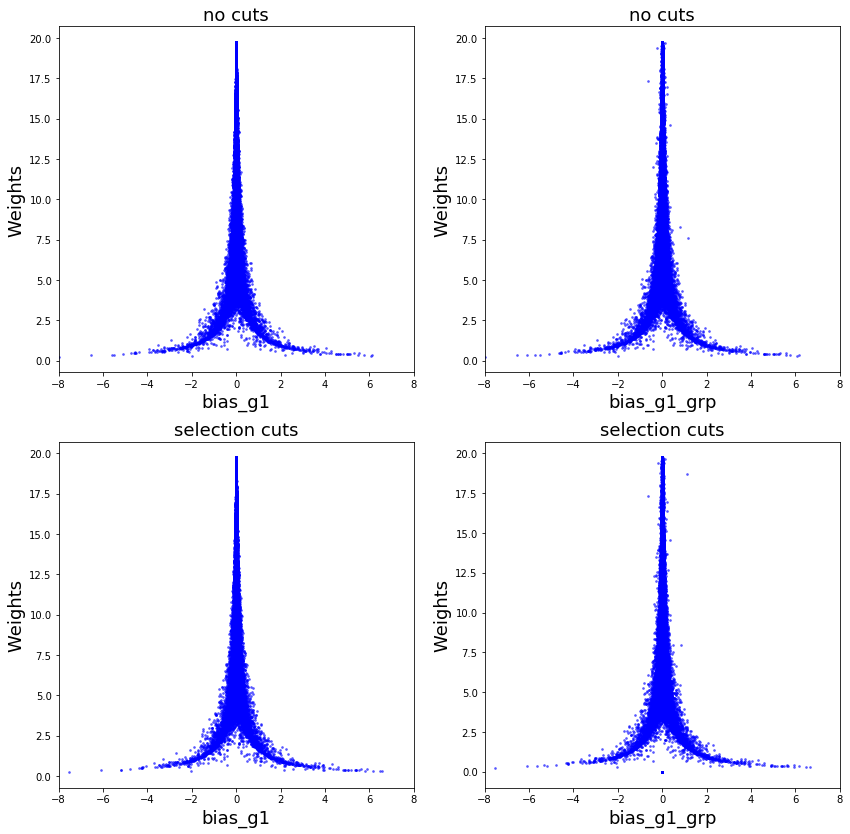

In [56]:
fig, axs = plt.subplots(2,2,figsize=(14,14))
axes = axs.flatten()
weights_bias_scatter(axes[0], fscat1, '1', 'iso', xlim=[-8,8], size_dots=3, alpha=0.5, 
                     xlabel="bias_g1", title="no cuts")

weights_bias_scatter(axes[1], fscat1, '1', 'grp', xlim=[-8,8], size_dots=3, alpha=0.5, 
                     xlabel="bias_g1_grp", title="no cuts")

weights_bias_scatter(axes[2], fscat2, '1', 'iso', xlim=[-8,8], size_dots=3, alpha=0.5, 
                     xlabel="bias_g1", title="selection cuts")

weights_bias_scatter(axes[3], fscat2, '1', 'grp', xlim=[-8,8], size_dots=3, alpha=0.5,
                     xlabel="bias_g1_grp", title="selection cuts")